# Implement a Intelligent Gift Recommendation System Using GPT-4o
OpenAI has released GPT-4o, which boasts enhanced vision abilities. In this example, we showcase a promising application for utilizing such multimodal AI models with a vector database: a gift recommendation system. 

In such a system, users need to provide a description of the person they want to send a gift to. The language model (LLM) will then offer some ideas for potential gifts. Subsequently, we will utilize multimodal search to explore these proposals in a gift database, and the LLM will make the final decision based on various factors.

## Dataset preparation
In this case, we will utilize Amazon review data, which encompasses numerous categories of products associated with reviews. For this purpose, we will download 100 images from each category. Although reviews can be a valuable resource for further study, we will not incorporate them in this initial example.


In [ ]:
!python download_images.py

## Multi-Modal encoder for gift retrieval
We need to utilize a multimodal retriever to retrieve the gift proposals in the database. Each gift contains both image and textual data. To effectively search through this data, we can employ a model that combines these two modalities into a single representative embedding. In this example, we will use [BGE-Visualized](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/visual), an advanced model designed for this purpose.

In order to use BGE-Visualized, we need to install FlagEmbedding and download the weights of the model.

In [ ]:
!pip install FlagEmbedding
!wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth --no-check-certificate

Then we define the Encoder which can encode the combination of text and image.


In [188]:
from FlagEmbedding.visual.modeling import Visualized_BGE
import torch
import numpy as np

class BGEVisualizedEncoder():
    def __init__(self):
        self.model = Visualized_BGE(model_name_bge = "BAAI/bge-base-en-v1.5", model_weight="./Visualized_base_en_v1.5.pth")

    def __call__(self, image=None, text=None):
        with torch.no_grad():
            if text == None:
                emb = self.model.encode(image=image)
            elif image == None:
                emb = self.model.encode(text=text)
            else:
                emb = self.model.encode(image=image, text=text)
        return emb.detach().cpu().flatten().numpy().astype(np.float32)
encoder = BGEVisualizedEncoder()

/mnt/david.wxy/Anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Insert the data to database
After define the encoder, we will use the encoder to encode the products information. The product has rich information both in preview images and title description.

In [ ]:
from datasets import load_dataset
from pymilvus import MilvusClient
import os
from PIL import Image
import json

def insert_data():
    client = MilvusClient("products.db")
    client.create_collection(
        collection_name="demo_collection",
        overwrite= True,
        auto_id = True,
        dimension=768,
        enable_dynamic_field=True
    )
    with open('categories.txt') as fw:
        lines = fw.readlines()
        for line in lines:
            l = line.strip()
            meta_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{l}", split="full")
            for i in range(100):
                if len(meta_dataset[i]['images']['large']) > 0: 
                    img_name = meta_dataset[i]['images']['large'][0]
                    name = os.path.basename(img_name)
                    if os.path.exists(f"images/{name}") is True: 
                        feat = encoder(image=f'images/{name}', text=meta_dataset[i]['title'])
                        spec = json.dumps(meta_dataset[i])

                        res = client.insert(
                            collection_name="demo_collection",
                            data={"vector": feat.flatten(), "spec":spec, "name": f"{l}_{i}"}
                        )
insert_data()

We can show a example of the information in a product item.

main_category Toys & Games
title Traxxas Stampede 4X4: 1/10 Scale 4wd Monster Truck, Red
average_rating 4.5
rating_number 48
features ['Waterproof electronics for all-weather driving excitement in water, mud and snow!', 'Powerful Titan 12-Turn 550 motor backed by the ultra-reliable XL-5 waterproof speed control', 'Includes Traxxas 7-cell NiMH battery with iD technology and 4-amp 12-volt DC peak-detecting fast charger for reliable charging', 'Chevron Maxx 2.8" tires with foam inserts pre-glued on chrome All-Star wheels', 'Tall ground clearance and trail tuned differentials make Stampede a true off-road beast']
description ['Stampede 4X4 is built Traxxas Tough to withstand all the 4WD mayhem you can dish out. Its high ground clearance and long-arm suspension make Stampede 4X4 feel nearly indestructible. Chrome All-Star 2.8" wheels give Stampede 4X4 aggressive style, and soft Chevron Maxx tires deliver all-terrain capability. It\'s all waterproof, so the fun keeps going through wet condit

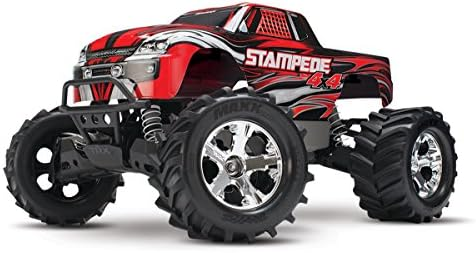

In [210]:
from IPython.display import Image
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Toys_and_Games", split="full")
for k in dataset[3]:
    print(k, dataset[3][k])
Image(f"images/{os.path.basename(dataset[3]['images']['large'][0])}")



## Gift proposal for description
In the first step, we will generate proposals using LLM given the description who you want to send this gift.

**Description**
 She loves outdoor activities and cooking, enjoys reading fantasy novels, has a passion for photography, and is interested in sustainable living.

In [211]:
from openai import OpenAI

api_key= "YOUR_OPENAI_API_KEY"
def generate_gift_choices(person_description):
    client = OpenAI(api_key)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant. User would give a person description, and you need to generate 5 diverse gift candidates, each one sould be short less than 5 words. Your answer should only have five lines of gifts. please do not add the index number."},
            {"role": "user", "content": person_description},
        ]
    )

    gifts = response.choices[0].message.content.split("\n")
    return gifts

person_description = "Description: She loves outdoor activities and cooking, enjoys reading fantasy novels, has a passion for photography, and is interested in sustainable living."
gift_choices = generate_gift_choices(person_description)
print("Gift choices for the person described:")
for i, choice in enumerate(gift_choices, start=1):
    print(f"{i}. {choice}")

Gift choices for the person described:
1. Hiking backpack  
2. Eco-friendly cooking gadgets  
3. Fantasy book set  
4. Photography lighting kit  
5. Reusable produce bags


## Using multi-modal search to retrieve gift candidates
We have a variety of gift proposals generated by LLMs, some of which exist in the database and can be purchased, while others do not. Therefore, we need to search for each proposal and gather a pool of options for our final decision. Multi-modal indexes have been inserted into the Milvus database. We now need to search it.

In [226]:
class MilvusSearch:
    def __init__(self, encoder, client, collection_name):
        self.encoder = encoder
        self.client = client
        self.collection_name = collection_name

    def search_text(self, text, limit=20, output_fields=None, search_params=None):
        emb = self.encoder(text=text)
        results = self.client.search(collection_name=self.collection_name, data=[emb], limit=limit, output_fields=output_fields, search_params=search_params)
        candidates = []
        for result in results:
            for i, hit in enumerate(result):
                obj = json.loads(hit["entity"]["spec"])
                candidates.append(obj)
        return candidates
client = MilvusClient("products.db")
searcher = MilvusSearch(encoder, client, "demo_collection")

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 864e223359ac418dbe4fc286f338aade



For each proposal in the proposals, we retrieve the nearest 3 product candidates, thus obtaining a pool of 15 products.

In [227]:
results = [searcher.search_text(gift_choice, 3, ["spec"], {"metric_type": "IP"}) for gift_choice in gift_choices ] 

candidates = []
candidates_image_names = []
for result in results:
    row = result
    for col in row:
        candidates.append(col)
        candidates_image_names.append(f"images/{os.path.basename(col['images']['large'][0])}")
print(len(candidates))

15


We want to present information in a panoramic view image so that LLM can view all the information in a single image. We arrange each proposal's candidate in a row and assign each product an index number to help LLM correlate it with textual information.

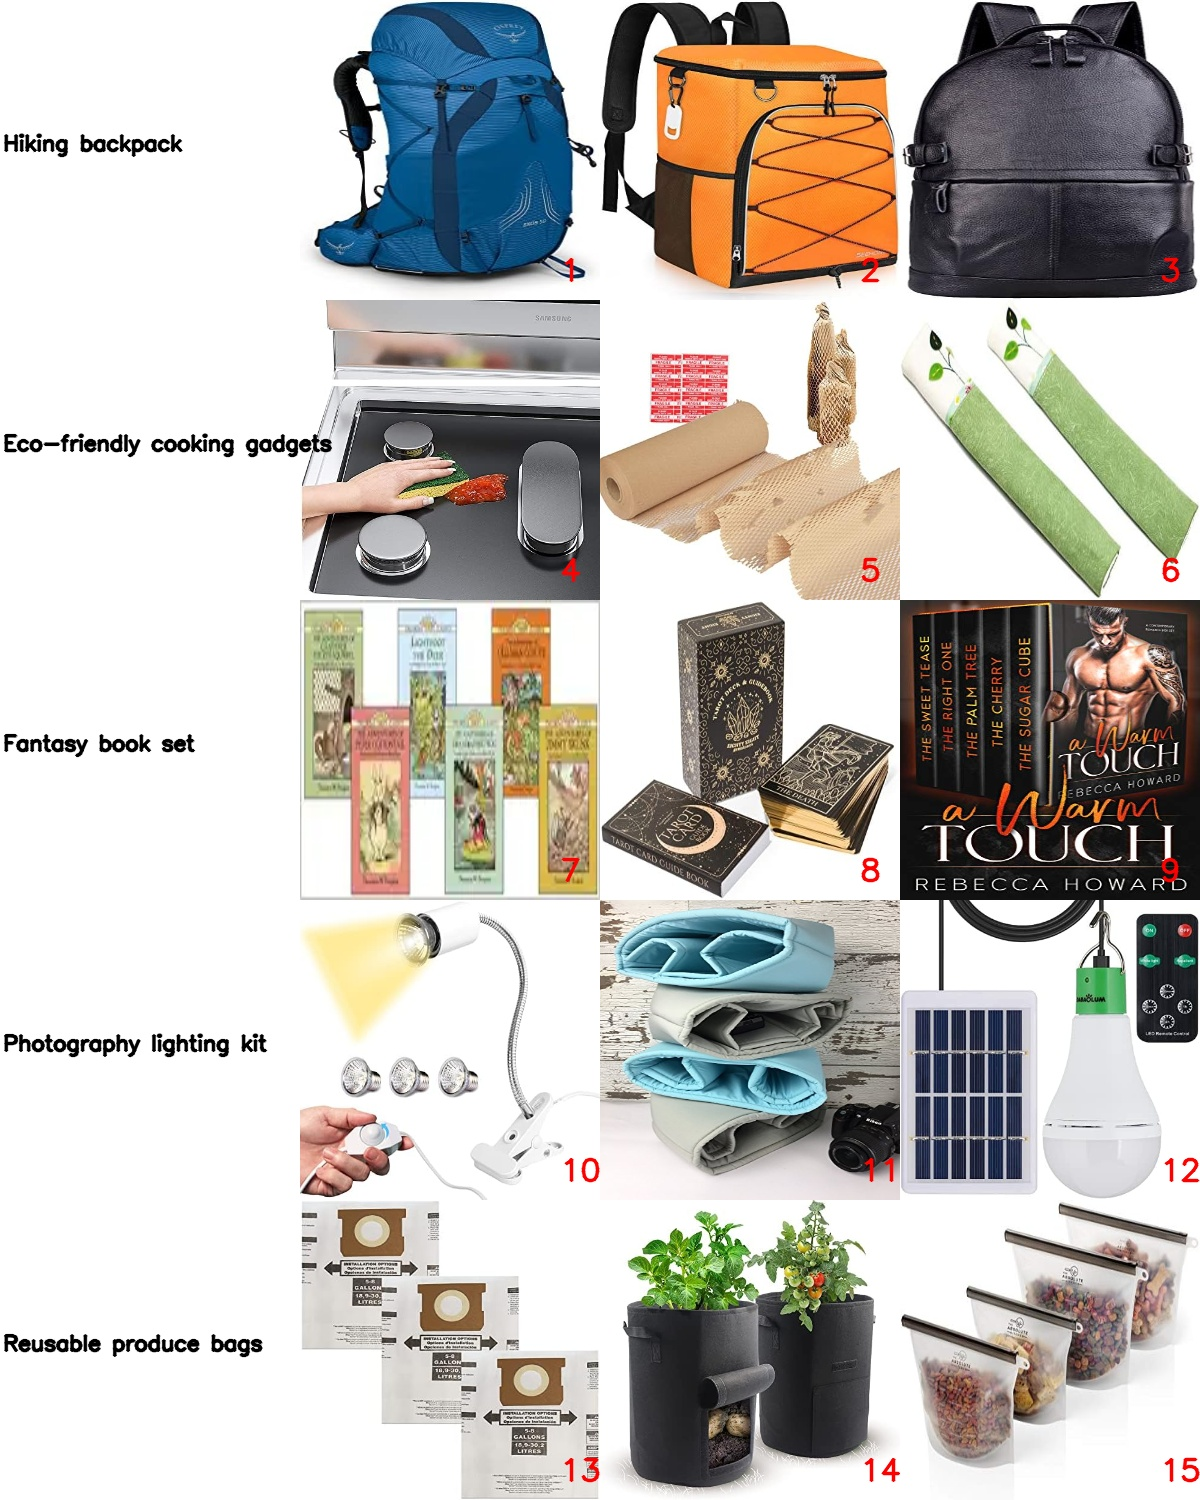

In [228]:
import cv2
import numpy as np
import IPython

# Function to create panoramic view image
def create_panoramic_view(image_names, text_labels):
    # Size of each individual image
    img_width = 300
    img_height = 300
    
    # Create a white panoramic image
    panoramic_width = img_width * 4
    panoramic_height = img_height * 5
    panoramic_image = np.full((panoramic_height, panoramic_width, 3), 255, dtype=np.uint8)
    
    # Load font
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Paste images with their indices
    for i, image_name in enumerate(image_names):
        # Load image
        image = cv2.imread(image_name)
        # Resize image if needed
        image = cv2.resize(image, (img_width, img_height))
        # Paste image on panoramic image
        row = i // 3
        col = i % 3
        if col == 2:
            cv2.putText(panoramic_image, text_labels[row], ((0) * img_width + 3, (row) * img_height + int(0.5*img_height)), font, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(panoramic_image, str(i + 1), ((col + 2) * img_width - 40, (row + 1) * img_height - 20), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
        panoramic_image[row * img_height:(row + 1) * img_height, (col+1) * img_width:(col + 2) * img_width] = image
        cv2.putText(panoramic_image, str(i + 1), ((col + 2) * img_width - 40, (row + 1) * img_height - 20), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    return panoramic_image

panoramic_view = create_panoramic_view(candidates_image_names, gift_choices)
cv2.imwrite('panoramic_view.jpg', panoramic_view) 
IPython.display.Image("panoramic_view.jpg", width="40%")

## Generate final gift decision
Now, we generate a panoramic view of all candidate products. We need to ask GPT-4o to generate the final decision based on multi-source information, descriptions, images, and ratings.

In [232]:
import base64
import requests


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "panoramic_view.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

information = "the information in this picture is listed shown below, each have the index number corresponding in the image: \n\n"
for i, candidate in enumerate(candidates):
    information += f" {i+1}. title: {candidate['title']} averate_rating: {candidate['average_rating']} rating_number: {candidate['rating_number']}\n"
    #print(candidate['title'], candidate['average_rating'], candidate['rating_number'])
information += f'''
{person_description}
now give you description of a person, you need use information in text and image to choose a single gift for him/her. you need consider both average rating, rating number and aesthetic of product.  
Ther first line will be the single index number, then you need to give the reason begin with "Reason:" in next line.
'''

payload = {
  "model": "gpt-4o",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": information 
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
print(response.json()['choices'][0]["message"]["content"])

8

Reason: The tarot cards set (index number 8) is an excellent choice given her love for reading fantasy novels. It has a high average rating of 4.6 from 193 reviews, ensuring quality and satisfaction. The intricate and aesthetically pleasing design of the mystical gold foil and black cards will also appeal to her interest in fantasy themes.


GPT-4o selects the 8th product for the final decision and provides a rational reason by considering the item's images, description, and rating information. Access to additional information could further improve the decision-making process.